<a href="https://colab.research.google.com/github/aminekhasteh/DeepLearningFinalReport2020/blob/master/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf
import numpy as np
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
main_dir = '/content/drive/My Drive/Colab Notebooks/Breast Cancer'

In [3]:
csv_stage = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Breast Cancer/brca-clinicalforwiki_TCIA.xlsx')

Converting the training data into tensor

In [4]:
training_names = os.listdir(main_dir + '/' + 'Training')
names=training_names[0]
miz = PIL.Image.open(main_dir + '/' + 'Training/' + names)
miz = miz.convert("L")
new = np.asarray(miz)
new_normalised = (new-new.mean())/new.std()
training_tensor = np.expand_dims(new_normalised, axis=0)
Y = [csv_stage.loc[csv_stage['bcr_patient_barcode'] == training_names[0][:-10]]['ajcc_neoplasm_disease_stage'].values[0]]
j=1
for names in training_names[1:]:
    Y.append(csv_stage.loc[csv_stage['bcr_patient_barcode'] == training_names[j][:-10]]['ajcc_neoplasm_disease_stage'].values[0])
    j=j+1
    miz = PIL.Image.open(main_dir + '/' + 'Training/' + names)
    miz = miz.convert("L")
    new = np.asarray(miz)
    new_normalised = (new-new.mean())/new.std()
    new_tensor = np.expand_dims(new_normalised, axis=0)
    #print(new_tensor.shape)
    training_tensor = np.concatenate((training_tensor, new_tensor), axis=0)

In [5]:
training_tensor.shape

(594, 256, 256)

Converting the testing data into tensor:

In [6]:
testing_names = os.listdir(main_dir + '/' + 'Testing')
names=testing_names[0]
miz1 = PIL.Image.open(main_dir + '/' + 'Testing/' + names)
miz1 = miz.convert("L")
new1 = np.asarray(miz1)
new_normalised1 = (new-new.mean())/new.std()
testing_tensor = np.expand_dims(new_normalised1, axis=0)
Y_test = [csv_stage.loc[csv_stage['bcr_patient_barcode'] == testing_names[0][:-10]]['ajcc_neoplasm_disease_stage'].values[0]]
k = 1
for names in testing_names[1:]:
    Y_test.append(csv_stage.loc[csv_stage['bcr_patient_barcode'] == testing_names[k][:-10]]['ajcc_neoplasm_disease_stage'].values[0])
    k=k+1
    miz = PIL.Image.open(main_dir + '/' + 'Testing/' + names)
    miz = miz.convert("L")
    new = np.asarray(miz)
    new_normalised = (new-new.mean())/new.std()
    new_tensor = np.expand_dims(new_normalised, axis=0)
    #print(new_tensor.shape)
    testing_tensor = np.concatenate((testing_tensor, new_tensor), axis=0)

In [7]:
testing_tensor.shape

(152, 256, 256)

Expanding the dataset one more time, we do this so the format of our data is right for training.

In [8]:
training_tensor = np.expand_dims(training_tensor, axis=3)
testing_tensor = np.expand_dims(testing_tensor, axis=3)

Description of our dataset:

In [9]:
print('Training shape:', training_tensor.shape)
print(training_tensor.shape[0], 'sample,',training_tensor.shape[1] ,'x',training_tensor.shape[2] ,'size grayscale image.\n')
print('Test shape:', testing_tensor.shape)
print(testing_tensor.shape[0], 'sample,',testing_tensor.shape[1] ,'x',testing_tensor.shape[2] ,'size grayscale image.\n')

Training shape: (594, 256, 256, 1)
594 sample, 256 x 256 size grayscale image.

Test shape: (152, 256, 256, 1)
152 sample, 256 x 256 size grayscale image.



Looking at the normalized transformed to tensor images

Examples:


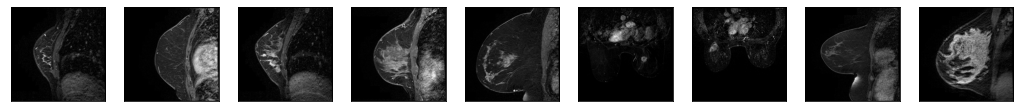

In [10]:
print('Examples:')
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(training_tensor[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Since our inputs are images, we used convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders because they perform better. Our encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder consists in a stack of Conv2D and UpSampling2D layers. 

In [11]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
input_img = Input(shape=(256, 256, 1))  # adapt this if using `channels_first` image data format
num_classes = 7

In [12]:
def encoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) 
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) 
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) 
    return decoded

In [151]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
#opt = keras.optimizers.Adadelta(learning_rate=0.00025,rho=0.95) 
opt = keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9)
autoencoder.compile(loss='mean_squared_error', optimizer = opt) 

In [149]:
autoencoder.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization_72 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_73 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 128, 128, 64)    

Now we train the data. First, we open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.

In [152]:
autoencoder_train = autoencoder.fit(training_tensor, training_tensor, 
                                    batch_size=64,
                                    epochs=100,
                                    validation_data=(testing_tensor, testing_tensor), 
                                    shuffle=True)

Epoch 1/100
10/10 [==============================] - 8s 814ms/step - loss: 1.0116 - val_loss: 1.7660
Epoch 2/100
10/10 [==============================] - 8s 797ms/step - loss: 0.6499 - val_loss: 0.9399
Epoch 3/100
10/10 [==============================] - 8s 806ms/step - loss: 0.6328 - val_loss: 0.7838
Epoch 4/100
10/10 [==============================] - 8s 810ms/step - loss: 0.6244 - val_loss: 0.6905
Epoch 5/100
10/10 [==============================] - 8s 802ms/step - loss: 0.6197 - val_loss: 0.6666
Epoch 6/100
10/10 [==============================] - 8s 798ms/step - loss: 0.6104 - val_loss: 0.6495
Epoch 7/100
10/10 [==============================] - 8s 789ms/step - loss: 0.6015 - val_loss: 0.7244
Epoch 8/100
10/10 [==============================] - 8s 788ms/step - loss: 0.6030 - val_loss: 0.6426
Epoch 9/100
10/10 [==============================] - 8s 785ms/step - loss: 0.5935 - val_loss: 0.6353
Epoch 10/100
10/10 [==============================] - 8s 786ms/step - loss: 0.5884 - val_lo

Plotting the loss function

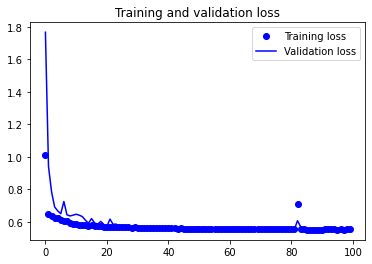

In [154]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Saving the complete autoencoder weights

In [155]:
autoencoder.save_weights('autoencoder.h5')

In [156]:
decoded_imgs = autoencoder.predict(testing_tensor)

Displaying the original against the reconstructed images through encoding and decoding.

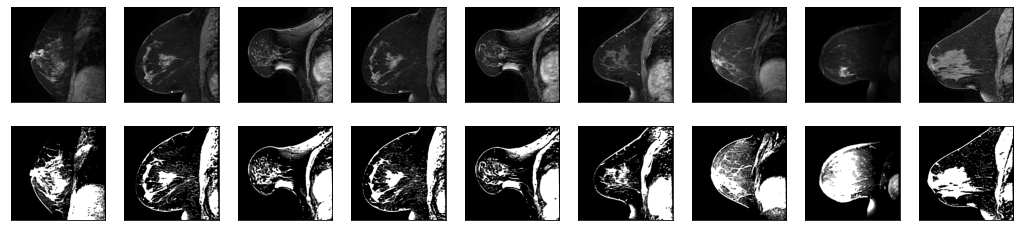

In [157]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(testing_tensor[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Creating dictionary of target classes

In [158]:
label_dict = {
 'Stage I':1,
 'Stage IA':2,
 'Stage II':3,
 'Stage IIA':4,
 'Stage IIB':5,
 'Stage IIIA':6,
 'Stage IIIC':7
}
num_classes = 7

Converting the response variables into categrocal dataframe.

In [159]:
y = pd.DataFrame (Y,columns=['Y'])
y = y.replace(label_dict)

y_test = pd.DataFrame (Y_test,columns=['Y_test'])
y_test = y_test.replace(label_dict)

Converting the labels into one-hot encoding vectors:

In [160]:
train_Y_one_hot = to_categorical(y)
test_Y_one_hot = to_categorical(y_test)

Creating validation set from the training set:

In [161]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(training_tensor,train_Y_one_hot,test_size=0.2,random_state=13)

Defininf the fully connected layers:

In [162]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [171]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [172]:
full_model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization_124 (Bat (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_125 (Bat (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 128, 128, 64)    

This function will give us a nice confusion matrix plot:

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Model evaluation on the Test set:

In [210]:
# Results on training

encode = full_model.predict(training_tensor)

predicted = np.argmax(encode, axis=1)
# class_dict = np.zeros((num_classes, num_classes))
# for i, sample in enumerate(Y):
# if sample=='Stage I':
#     class_dict[np.argmax(encode[i], axis=0)][1] += 1
# if sample=='Stage IA':
#     class_dict[np.argmax(encode[i], axis=0)][2] += 1
# if sample=='Stage II':
#     class_dict[np.argmax(encode[i], axis=0)][3] += 1
# if sample=='Stage IIA':
#     class_dict[np.argmax(encode[i], axis=0)][4] += 1
# if sample=='Stage IIB':
#     class_dict[np.argmax(encode[i], axis=0)][5] += 1
# if sample=='Stage IIIA':
#     class_dict[np.argmax(encode[i], axis=0)][6] += 1
# if sample=='Stage IIIB':
#     class_dict[np.argmax(encode[i], axis=0)][7] += 1

# print(class_dict)

# neuron_class = np.zeros((num_classes))
# for i in range(num_classes):
# neuron_class[i] = np.argmax(class_dict[i], axis=0)

# print(neuron_class)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


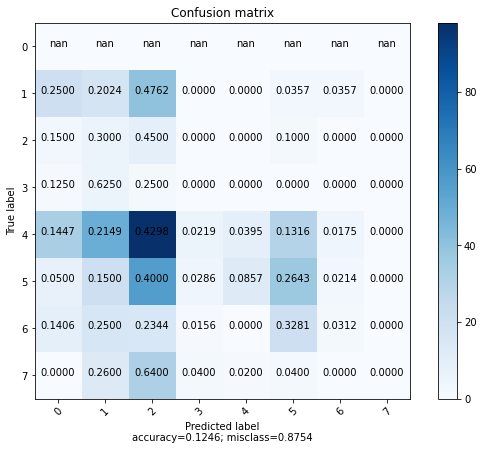

In [211]:
from sklearn.metrics import confusion_matrix
import pylab as pl
cm = confusion_matrix(y, predicted)
plot_confusion_matrix(cm,[0,1,2,3,4,5,6,7])

In [ ]:
# Results on testing

encode = full_model.predict(testing_tensor)

predicted = np.argmax(encode, axis=1)
for i, sample in enumerate(predicted):
    predicted[i] = neuron_class[predicted[i]]

comparison = []
for i in range(len(Y_test)):
    if predicted[i]==1:
        pred = 'Stage I'
    if predicted[i]==2:
        pred = 'Stage IA'
    if predicted[i]==3:
        pred = 'Stage II'
    if predicted[i]==4:
        pred = 'Stage IIA'
    if predicted[i]==5:
        pred = 'Stage IIB'
    if predicted[i]==6:
        pred = 'Stage IIIA'
    if predicted[i]==7:
        pred = 'Stage IIIB'
        
    if Y_test[i]==pred:
        comparison.append(1)
    else:
        comparison.append(0)

loss = 1 - np.sum(comparison)/len(Y_test)

print('Loss:', loss)
print('Examples:')
for i in range(10):
    plt.imshow(testing_tensor[i].reshape(256,256), cmap='gray')
    plt.axis('off')
    plt.show()
    neuron = np.argmax(encode[i], axis=0)
    print('Class:', Y_test[i], '- Model\'s Output Class:', neuron_class[neuron])

class_dict = np.zeros((num_classes, num_classes))
for i, sample in enumerate(Y_test):
    if sample=='Stage I':
        class_dict[np.argmax(encode[i], axis=0)][1] += 1
    if sample=='Stage IA':
        class_dict[np.argmax(encode[i], axis=0)][2] += 1
    if sample=='Stage II':
        class_dict[np.argmax(encode[i], axis=0)][3] += 1
    if sample=='Stage IIA':
        class_dict[np.argmax(encode[i], axis=0)][4] += 1
    if sample=='Stage IIB':
        class_dict[np.argmax(encode[i], axis=0)][5] += 1
    if sample=='Stage IIIA':
        class_dict[np.argmax(encode[i], axis=0)][6] += 1
    if sample=='Stage IIIB':
        class_dict[np.argmax(encode[i], axis=0)][7] += 1

print(class_dict)

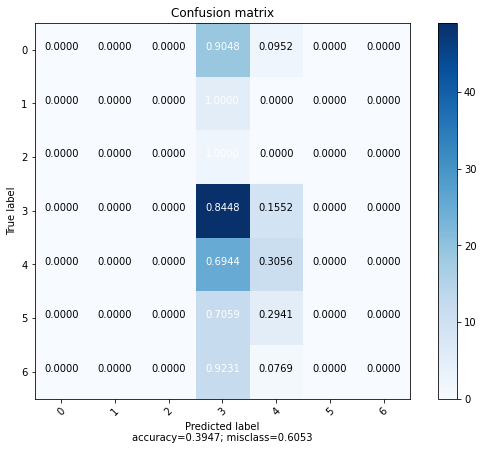

In [204]:
from sklearn.metrics import confusion_matrix
import pylab as pl
cm = confusion_matrix(y_test, predicted)
plot_confusion_matrix(cm,[0,1,2,3,4,5,6])

In [214]:
predicted

array([4, 5, 5, 4, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 5, 5, 4, 4, 5, 4, 5,
       4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4,
       4, 4, 4, 5, 4, 4, 4, 5, 4, 5, 4, 4, 5, 4, 5, 5, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4])